In [1]:
import itertools
import functools
import dataclasses
import packaging.version
from typing import List, Sequence, Set, Iterator, Optional

import libmambapy

import mamba_error_reporting as mer

# Problem definition

## PubGrub Example

The example given by Natalie Weizenbaum (image credits https://nex3.medium.com/pubgrub-2fb6470504f)

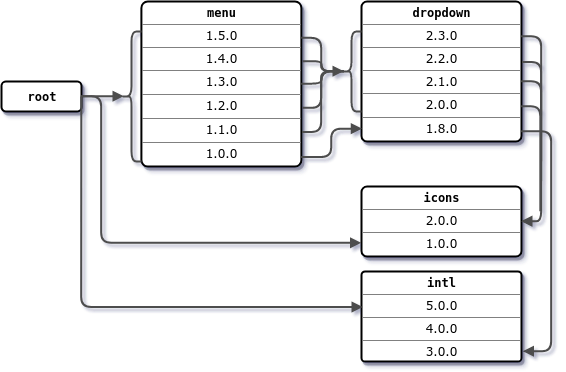

### Ideal output (from PubGrub)
```
Because dropdown >=2.0.0 depends on icons >=2.0.0 and root depends
  on icons <2.0.0, dropdown >=2.0.0 is forbidden.

And because menu >=1.1.0 depends on dropdown >=2.0.0, menu >=1.1.0
  is forbidden.

And because menu <1.1.0 depends on dropdown >=1.0.0 <2.0.0 which
  depends on intl <4.0.0, every version of menu requires intl
  <4.0.0.

So, because root depends on both menu >=1.0.0 and intl >=5.0.0,
  version solving failed.
```

# Conflict analysis

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
solver, pool = mer.problems.create_pubgrub_hard()
success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

Mamba failed to solve. The reported errors are:
   Encountered problems while solving:
     - package menu-1.2.0 requires dropdown 2.**, but none of the providers can be installed
   


In [4]:
pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

In [5]:
pbs

,type,source_id,source_is_pkg,dependency,dependency_id,target_id,target_is_pkg,explanation
0,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,8,True,dropdown 2.**,-2147483642,0,False,"package menu-1.2.0 requires dropdown 2.**, but..."
1,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,15,True,libicons 2.**,-2147483634,0,False,"package dropdown-2.1.0 requires libicons 2.**,..."
2,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,16,True,libicons 2.**,-2147483634,0,False,"package dropdown-2.0.0 requires libicons 2.**,..."
3,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,13,True,libicons 2.**,-2147483634,0,False,"package dropdown-2.3.0 requires libicons 2.**,..."
4,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,32,True,None,0,27,True,cannot install both libicons-1.0.0 and libicon...
5,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,32,True,None,0,28,True,cannot install both libicons-1.0.0 and libicon...
6,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,32,True,None,0,29,True,cannot install both libicons-1.0.0 and libicon...
7,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,21,True,libicons 1.**,-2147483627,0,False,"package pyicons-1.0.0 requires libicons 1.**, ..."
8,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,31,True,None,0,27,True,cannot install both libicons-1.2.0 and libicon...
9,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,31,True,None,0,28,True,cannot install both libicons-1.2.0 and libicon...


In [6]:
deps

,dependency_id,solvable_id
0,-2147483642,13
1,-2147483642,14
2,-2147483642,15
3,-2147483642,16
4,-2147483634,27
5,-2147483634,28
6,-2147483634,29
7,-2147483627,30
8,-2147483627,31
9,-2147483627,32


In [7]:
solvables

,name,version,build_string,build_number
id,,,,
2,menu,2.1.0,,0
3,menu,2.0.1,,0
4,menu,2.0.0,,0
5,menu,1.5.0,,0
6,menu,1.4.0,,0
7,menu,1.3.0,,0
8,menu,1.2.0,,0
9,menu,1.1.0,,0
10,menu,1.0.0,,0


In [8]:
import networkx as nx

def plot_dag(graph: nx.DiGraph, node_labels=None, edge_labels=None) -> None:
    plt.figure(figsize=(10, 6), dpi=300)

    # Position using levels
    pos = {}
    for level, nodes in enumerate(nx.topological_generations(graph)):
        nodes = sorted(nodes, key=lambda n: graph[n].get("name", "None"))
        pos.update({n: (x, -level - 0.2*(x%2)) for x, n in enumerate(nodes)})

    options = {"node_size": 800, "alpha": 0.5}
    nx.draw_networkx_nodes(graph, pos, node_color="blue", **options)
    nx.draw_networkx_edges(graph, pos, **options)

    if node_labels is not None:
        nx.draw_networkx_labels(graph, pos, node_labels, font_size=7)
    if edge_labels is not None:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels, font_size=7)

    plt.tight_layout()
    plt.axis("off")
    plt.show()


def repr_pkg_info(p: libmambapy.PackageInfo) -> str:
    return f"{p.name}-{p.version}-{p.build_number}"

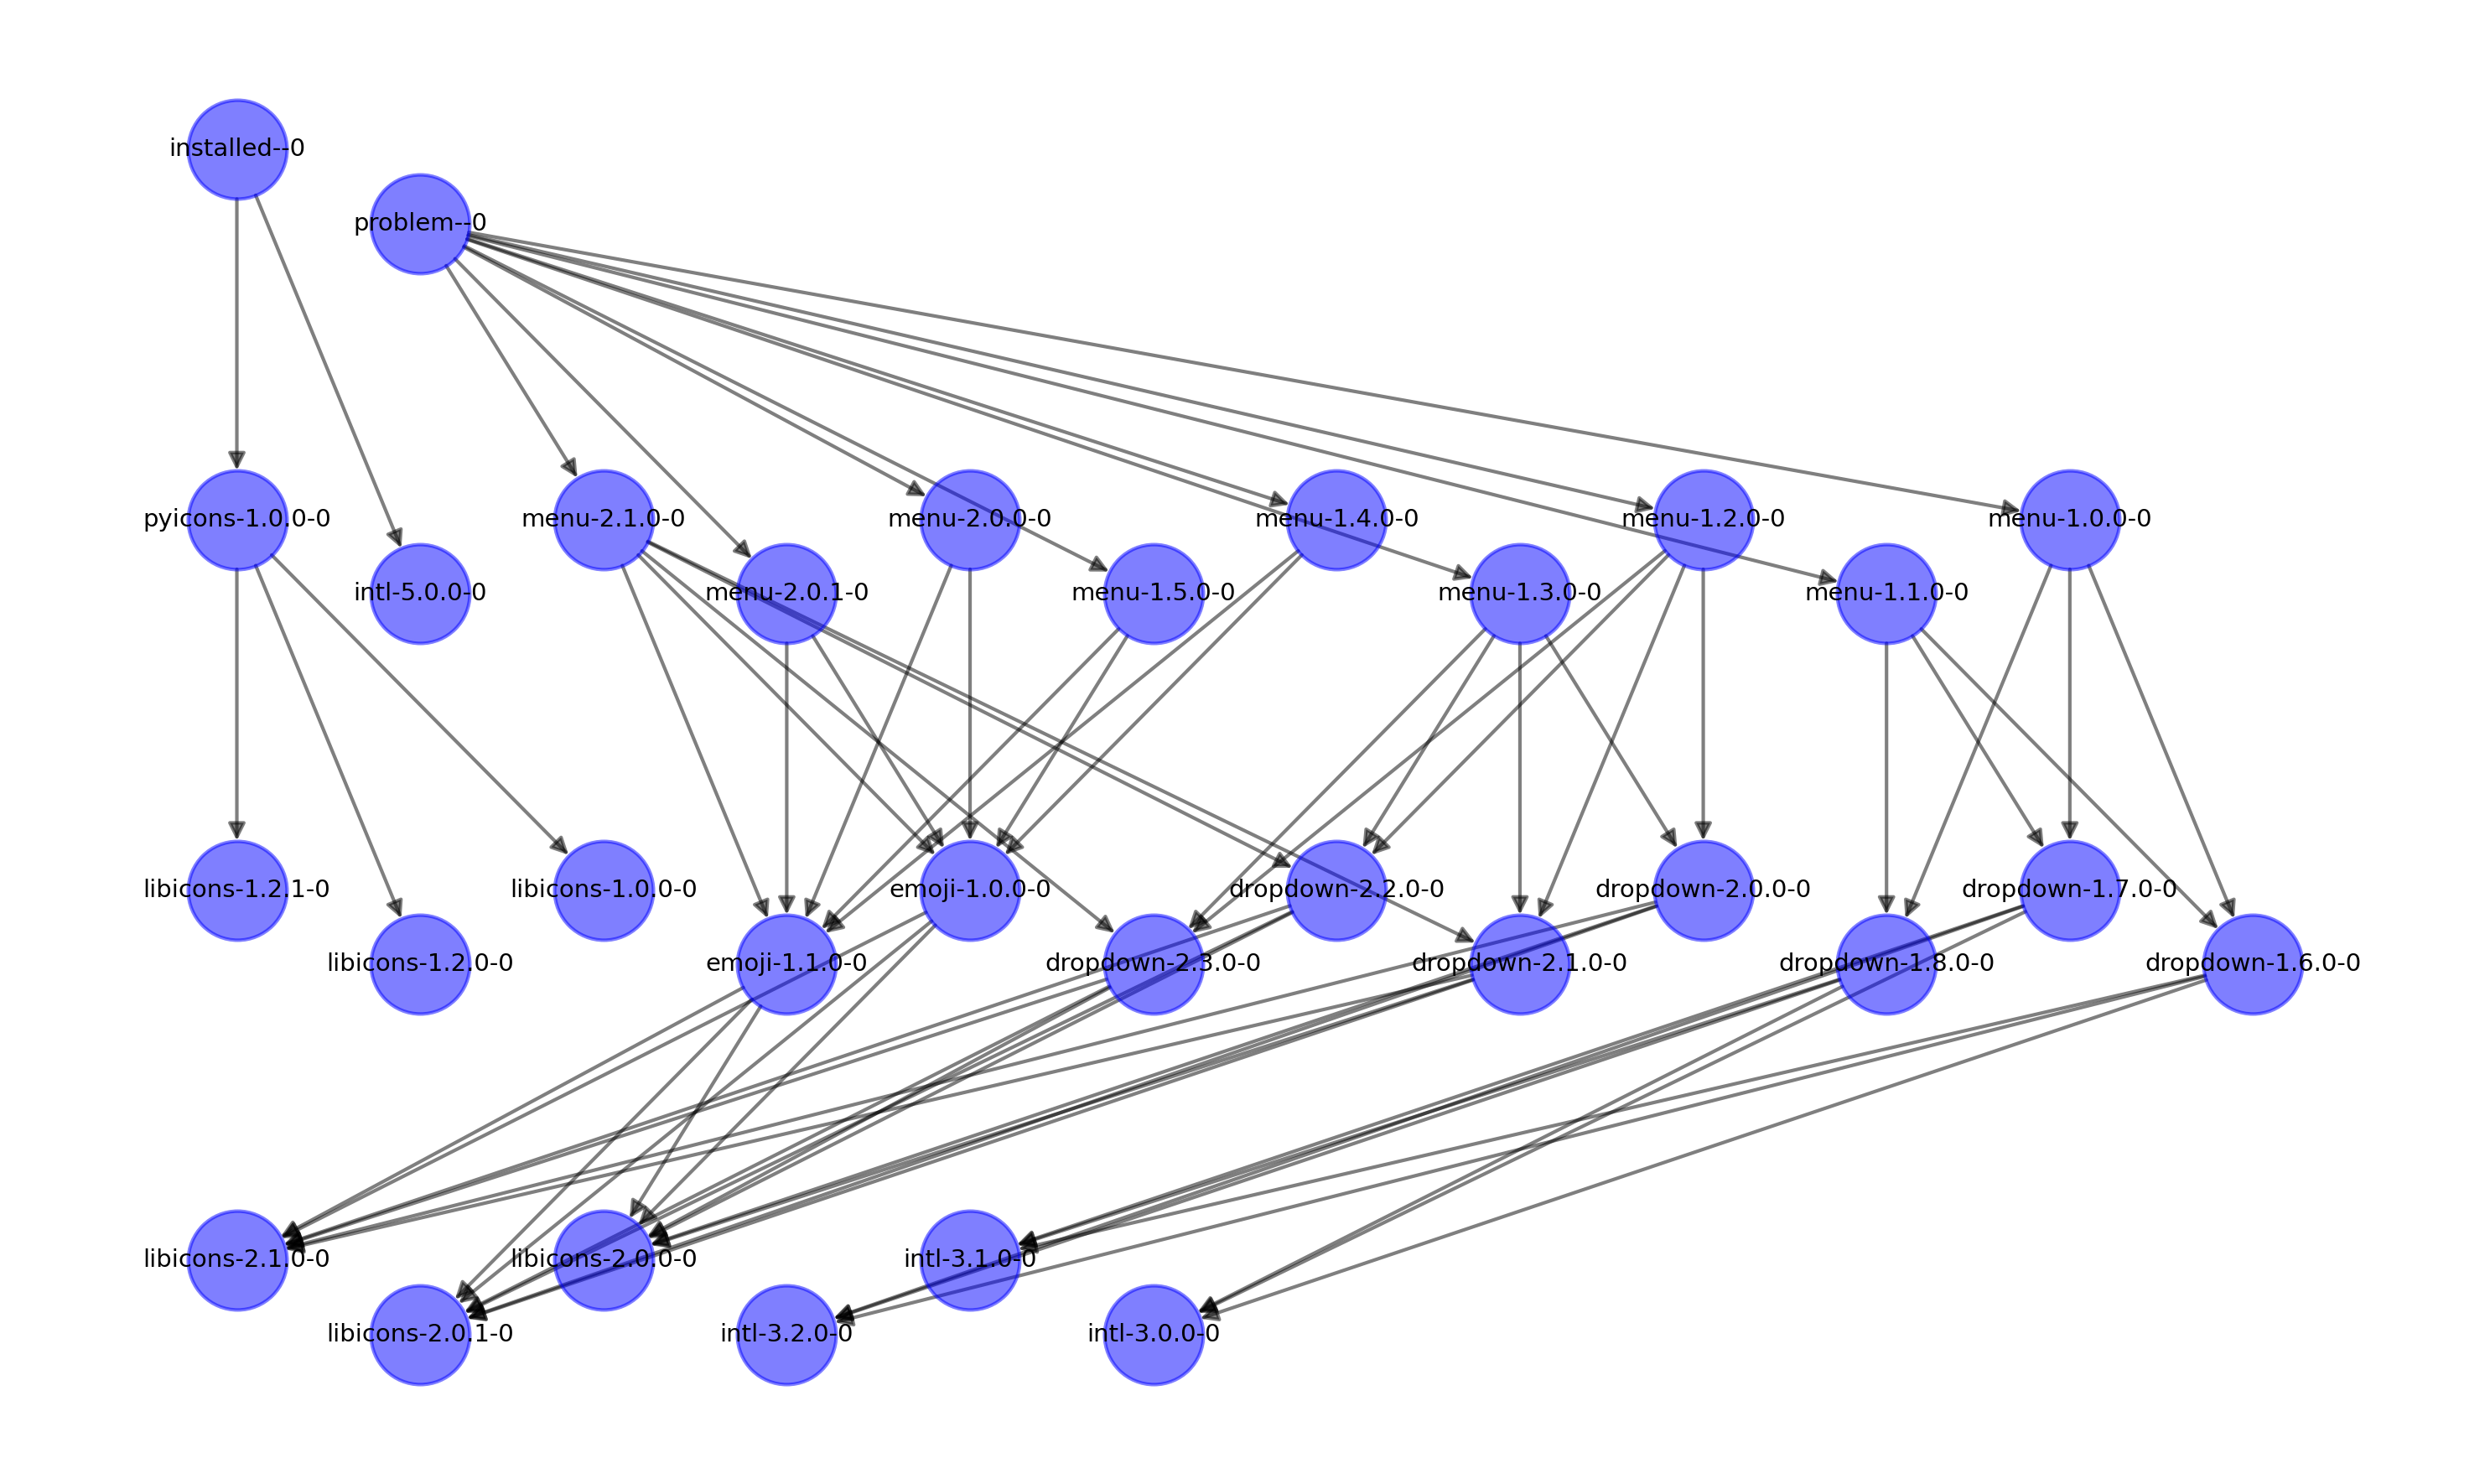

In [9]:
pb_data = mer.algorithm.ProblemData.from_libsolv(solver, pool)
plot_dag(pb_data.graph, node_labels={n: repr_pkg_info(pb_data.package_info[n]) for n in pb_data.graph.nodes})

In [10]:
g_compressed, groups = mer.algorithm.compress_graph(pb_data)

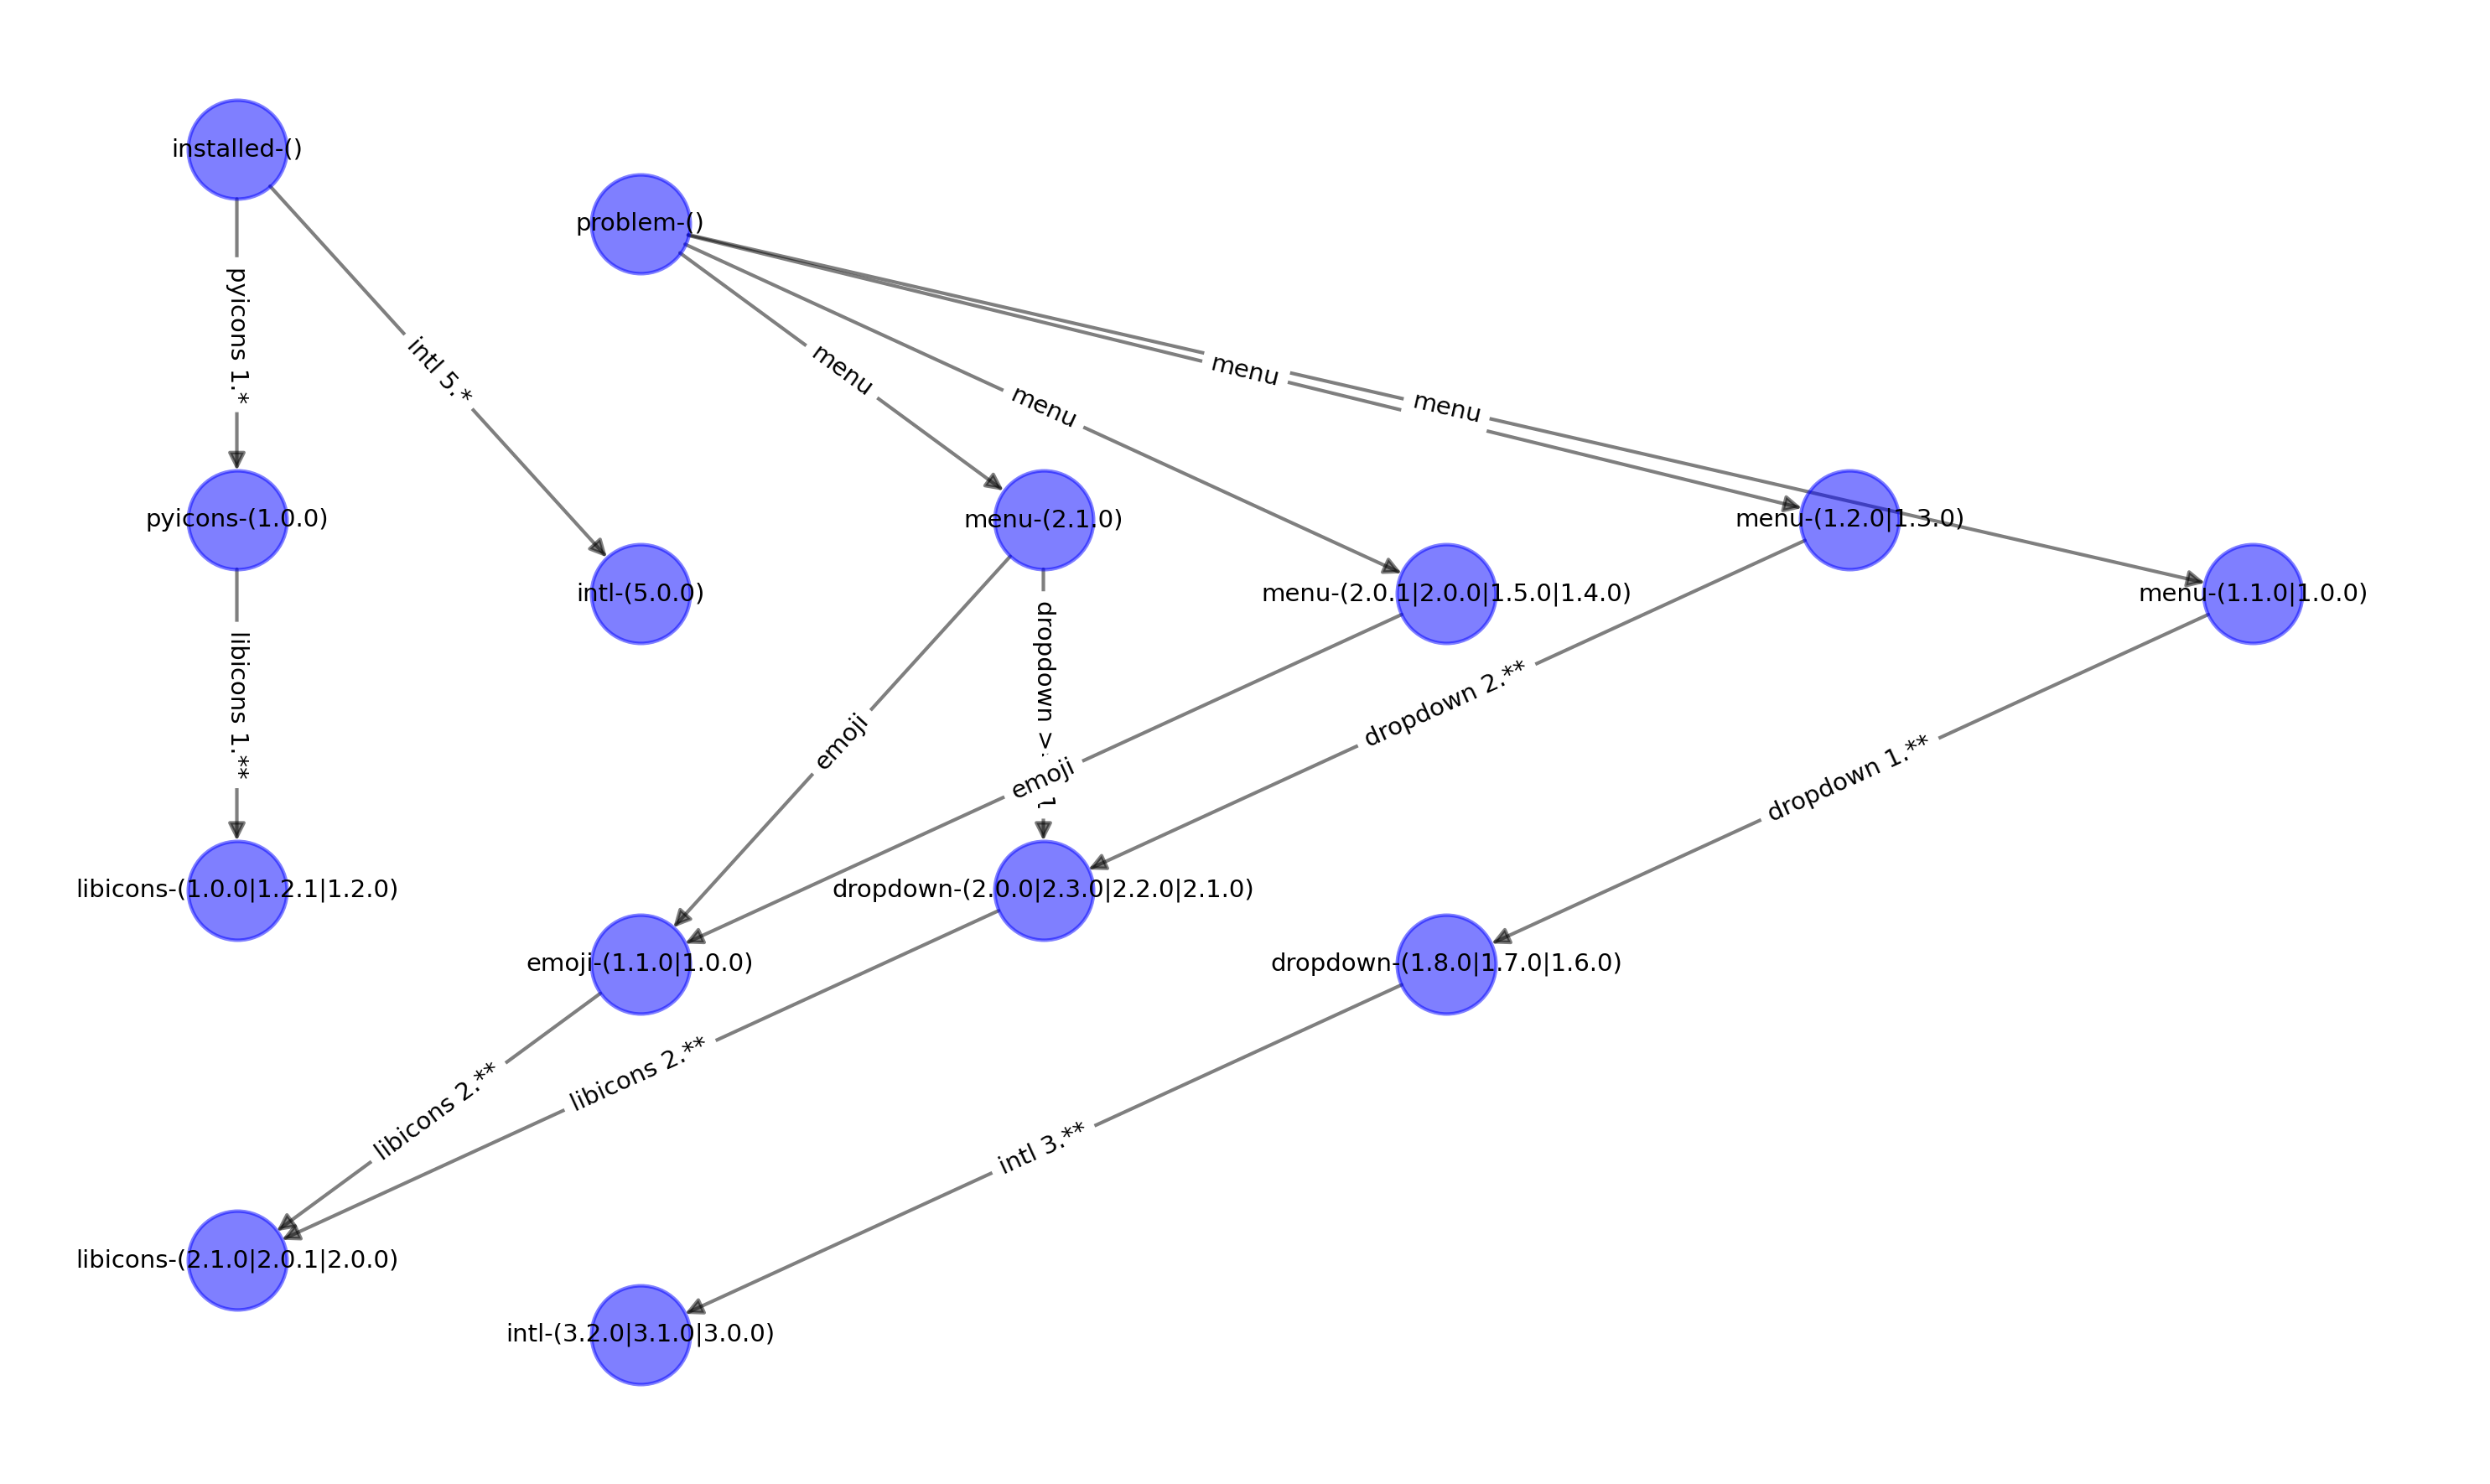

In [11]:
def graph_groups_labels(graph: nx.DiGraph, package_info, groups) -> dict:
    labels = {}
    for n in graph.nodes:
        solvs = [package_info.get(s) for s in groups.group_to_solv[n]]
        name = next(iter(solvs)).name
        versions = [p.version for p in solvs]
        # Truncate versions too long
        if len(versions) > 5:
            versions = versions[:2] + ["..."] + versions[-1:]
        labels[n] = f"{name}-(" + "|".join(versions) + ")"
    return labels


plot_dag(
    g_compressed,
    node_labels=graph_groups_labels(g_compressed, pb_data.package_info, groups),
    edge_labels={e: pb_data.dependency_names[attr["dependency_id"]] for e, attr in g_compressed.edges.items()},
)

In [12]:
import packaging.version
import enum


class Colors:
 
    class Style(enum.Enum):
        none = ""
        reset = '\033[0m'
        bold = '\033[01m'
        disable = '\033[02m'
        underline = '\033[04m'
        reverse = '\033[07m'
        strikethrough = '\033[09m'
        invisible = '\033[08m'
 
    class Fg(enum.Enum):
        none = ""
        black = '\033[30m'
        red = '\033[31m'
        green = '\033[32m'
        orange = '\033[33m'
        blue = '\033[34m'
        purple = '\033[35m'
        cyan = '\033[36m'
        lightgrey = '\033[37m'
        darkgrey = '\033[90m'
        lightred = '\033[91m'
        lightgreen = '\033[92m'
        yellow = '\033[93m'
        lightblue = '\033[94m'
        pink = '\033[95m'
        lightcyan = '\033[96m'
 
    class Bg(enum.Enum):
        none = ""
        black = '\033[40m'
        red = '\033[41m'
        green = '\033[42m'
        orange = '\033[43m'
        blue = '\033[44m'
        purple = '\033[45m'
        cyan = '\033[46m'
        lightgrey = '\033[47m'
    
    @classmethod
    def color(cls, str, fg: Fg|str = Fg.none, bg: Bg|str = Bg.none, style: Style|str = Style.none) -> str:
        fg = fg if isinstance(fg, cls.Fg) else getattr(cls.Fg, fg)
        bg = bg if isinstance(bg, cls.Bg) else getattr(cls.Bg, bg)
        style = style if isinstance(style, cls.Style) else getattr(cls.Style, style)
        return f"{fg.value}{bg.value}{style.value}{str}{cls.Style.reset.value}"


@dataclasses.dataclass
class Names:
    group_graph: nx.DiGraph
    pb_data: mer.algorithm.ProblemData
    groups: mer.algorithm.SolvableGroups
    
    def group_name(self, group_id) -> str:
        sample_solv_id = next(iter(self.groups.group_to_solv[group_id]))
        return self.pb_data.package_info[sample_solv_id].name
    
    def group_versions(self, group_id) -> list[str]:
        return list(set([pb_data.package_info[s].version for s in groups.group_to_solv[group_id]]))
    
    def group_versions_trunc(self, group_id, trunc_threshold: int = 5, trunc_show: int=2, trunc_str="...") -> list[str]:
        versions = self.group_versions(group_id)
        if len(versions) > trunc_threshold:
            return versions[:trunc_show] + [trunc_str] + versions[-trunc_show:]
        return versions
    
    def group_versions_range(self, group_id, range_sep="->") -> list[str]:
        parsed_versions = [packaging.version.parse(v) for v in self.group_versions(group_id)]
        return [str(min(parsed_versions)), range_sep, str(max(parsed_versions))]

    def edge_dependency_name(self, e) -> str:
        return self.pb_data.dependency_names[self.group_graph.edges[e]["dependency_id"]]
    
    def dependency_name(self, dep_id) -> str:
        return self.pb_data.dependency_names[dep_id]

In [13]:
@dataclasses.dataclass
class Explainer:
    names: Names
    indent: str = "  "
    
    def explain(self, path) -> str:
        lines = []
        for depth, dep_id_from, node, type in path:
            if dep_id_from is None:
                continue
            lines += [
                self.indent * depth + 
                "".join(getattr(self, f"explain_{type.value}")(depth, dep_id_from, node)),
            ]
            
        return "\n".join(lines) + "."
        
        
class ProblemExplainer(Explainer):
    def explain_single(self, depth, dep_id_from, node) -> tuple[str]:
        return (
            "This implies that " if depth <= 1 else "",
            self.names.dependency_name(dep_id_from),
            " cannot be installed because it requires" if depth <= 1 else ", which requires",
        )

    def explain_multi_split(self, depth, dep_id_from, node):
        return self.explain_single(depth, dep_id_from, node)

    def explain_multi_elem(self, depth, dep_id_from, node):
         return (
            "This implies that " if depth <= 1 else "",
            self.names.group_name(node),
            " [" + "|".join(self.names.group_versions_trunc(node)) + "]",
            " cannot be installed because it requires" if depth <= 1 else ", which requires",
        )

    def explain_leaf(self, depth, dep_id_from, node):
        return (
            "This implies that " if depth <= 1 else "",
            self.names.dependency_name(dep_id_from),
            " cannot be installed because it conflicts" if depth <= 1 else ", which conflicts",
            " with the requested versions of {TODO}",
        )
    
    def explain_visited(self, depth, dep_id_from, node):
        return self.explain_leaf(depth, dep_id_from, node) + (" (already explained)",)
    
    
class InstallExplainer(Explainer):
    def explain_single(self, depth, dep_id_from, node) -> tuple[str]:
        return (
            "A package satisfying " if depth <= 1 else "and so ",
            self.names.dependency_name(dep_id_from),
            " is requested",
        )

    def explain_multi_split(self, depth, dep_id_from, node):
        return self.explain_single(depth, dep_id_from, node) + (" and so one of",)

    def explain_multi_elem(self, depth, dep_id_from, node):
         return (
            self.names.group_name(node),
            " [" + "|".join(self.names.group_versions_trunc(node)) + "]",
            " is requested",
        )

    def explain_leaf(self, depth, dep_id_from, node):
        return self.explain_single(depth, dep_id_from, node) + (" and has to be installed",)
    
    def explain_visited(self, depth, dep_id_from, node):
        return self.explain_leaf(depth, dep_id_from, node) + (" (already explained)",)


# Groups may be superset of the dependencies
def make_dep_id_to_groups(graph: nx.DiGraph):
    groups = {}
    for (_, s), attr in graph.edges.items():
        groups.setdefault(attr["dependency_id"], set()).add(s)
    return groups


def package_same_name_groups(problems_by_type, groups):
    return set(
        tuple(sorted((groups.solv_to_group[p.source_id], groups.solv_to_group[p.target_id])))
        for p in problems_by_type[libmambapy.SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME]
    )


def explain(graph_compressed, pb_data, groups):
    names = Names(graph_compressed, pb_data, groups)


    install_root = groups.solv_to_group[-1]
    problem_root = groups.solv_to_group[0]

    dep_id_to_groups = make_dep_id_to_groups(graph_compressed)
    is_multi = {dep_id: len(group) > 1 for dep_id, group in dep_id_to_groups.items()}
    
    # FIXME This won't work if there are mutliple problem dependencies
    # Could that be the case? -> Make tests
    problem_name = pb_data.dependency_names[graph_compressed.edges[next(iter(graph_compressed.out_edges(problem_root)))]["dependency_id"]]
    print(f"Error: Could not install any versions from requested package {problem_name}")
    for conflict_a, conflict_b in package_same_name_groups(pb_data.problems_by_type, groups):
        graph_a = mer.algorithm.ancestors_subgraph(graph_compressed, conflict_a)
        graph_b = mer.algorithm.ancestors_subgraph(graph_compressed, conflict_b)
        root_a = mer.algorithm.find_root(graph_a, conflict_a)
        root_b = mer.algorithm.find_root(graph_b, conflict_b)
        graphs = {root_a: graph_a, root_b: graph_b}
        conflicts = {root_a: conflict_a, root_b: conflict_b}
        
        installed_name = names.group_name(conflicts[install_root])
        visited = set()

        print()
        inst_explainer = InstallExplainer(names)
        print(
            inst_explainer.explain(
                mer.algorithm.explanation_path(graphs[install_root], install_root, visited, is_multi)
            )
        )
                
        pb_explainer = ProblemExplainer(names)
        print(
            pb_explainer.explain(
                mer.algorithm.explanation_path(graphs[problem_root], problem_root, visited, is_multi)
            )
        )

In [14]:
explain(g_compressed, pb_data, groups)

Error: Could not install any versions from requested package menu

  A package satisfying pyicons 1.* is requested
    and so libicons 1.** is requested and has to be installed.
  This implies that menu cannot be installed because it requires
    menu [1.2.0|1.3.0], which requires
      dropdown 2.**, which requires
        libicons 2.**, which conflicts with the requested versions of {TODO}
    menu [1.4.0|1.5.0|2.0.0|2.0.1], which requires
      emoji, which requires
        libicons 2.**, which conflicts with the requested versions of {TODO}
    menu [2.1.0], which requires
      emoji, which conflicts with the requested versions of {TODO} (already explained).

  A package satisfying intl 5.* is requested and has to be installed.
  This implies that menu cannot be installed because it requires
    menu [1.0.0|1.1.0], which requires
      dropdown 1.**, which requires
        intl 3.**, which conflicts with the requested versions of {TODO}.
